In [46]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [47]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def sigmoid_backward(dA, cache):
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def relu(Z):
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [48]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    W1=np.random.randn(n_h,n_x) * 0.01
    b1=np.zeros((n_h,1))
    W2=np.random.randn(n_y,n_h) * 0.01
    b2=np.zeros((n_y,1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [95]:
def initialize_parameters_deep(layer_dims):
    
        np.random.seed(3)
        parameters = {}
        L = len(layer_dims)
        
        for l in range(1, L):
            parameters["W"+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1])/np.sqrt(layer_dims[l-1])
            parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
            
            assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
            assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
        return parameters

In [50]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

In [51]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

In [52]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A,parameters["W" + str(l)],parameters["b" + str(l)],"relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A,parameters["W" + str(L)],parameters["b" + str(L)],"sigmoid")
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))
    return AL, caches

In [53]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -1/m*(np.dot(Y,np.log(AL).T)+np.dot(1-Y,np.log(1-AL).T))
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

In [54]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1/m*np.dot(dZ,A_prev.T)
    db = 1/m*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db

In [55]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    return dA_prev, dW, db

In [56]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL =  - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [57]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads["dW" + str(l + 1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads["db" + str(l + 1)]
    
    return parameters

In [58]:
import time
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from PIL import Image
from scipy import ndimage
np.set_printoptions(threshold=sys.maxsize)

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import pickle as pkl
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
#pkl.dump(train_x_orig, open("train_x_orig1", "wb"))
#pkl.dump(train_y, open("train_y", "wb"))
#pkl.dump(test_x_orig, open("test_x_orig", "wb"))
#pkl.dump(test_y, open("test_y", "wb"))
#pkl.dump(classes, open("classes", "wb"))
train_x_orig = pkl.load(open("training_images/train_x_orig", "rb"))
train_y = pkl.load(open("training_images/train_y", "rb"))
test_x_orig = pkl.load(open("training_images/test_x_orig", "rb"))
test_y = pkl.load(open("training_images/test_y", "rb"))
classes = pkl.load(open("training_images/classes", "rb"))

y = 1. It's a cat picture.


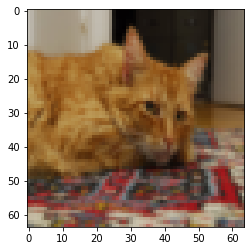

In [60]:
# Example of a picture
index = 97
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [61]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [62]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [144]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [145]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X,parameters["W1"],parameters["b1"],"relu")
        A2, cache2 = linear_activation_forward(A1,parameters["W2"],parameters["b2"],"sigmoid")
        
        # Compute cost
        cost = compute_cost(A2,Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters,grads,learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
 
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203889
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.27491377282130164
Cost after iteration 1300: 0.24681768210614854
Cost after iteration 1400: 0.19850735037466102
Cost after iteration 1500: 0.1744831811255661
Cost after iteration 1600: 0.1708076297809678
Cost after iteration 1700: 0.11306524562164705
Cost after iteration 1800: 0.09629426845937149
Cost after iteration 1900: 0.08342617959726864
Cost after iteration 2000: 0.07439078704319083
Cost after iteration 2100: 0.066307481322

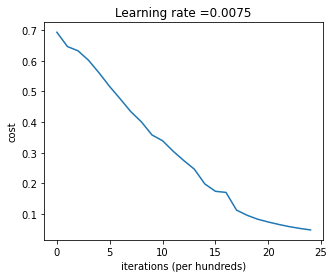

In [146]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [105]:
def predict(z1, z2, z3, w):
    if (w=="L"):
        z4=L_model_forward(z1,z3)[0]
    if (w=="2"):
        z4= linear_activation_forward(z1,z3["W1"],z3["b1"],"relu")[0]
        z4= linear_activation_forward(z4,z3["W2"],z3["b2"],"sigmoid")[0]
    z4=z4>0.5
    z5=np.zeros(z2.shape[1])
    z5=(z4==z2)
    z5=np.sum(z5)/(len(z5)*len(z5[0]))
    return z5

In [106]:
predictions_train = predict(train_x,train_y,parameters,"2")
print ("Accuracy:",predictions_train)

Accuracy: 1.0


In [107]:
predictions_test = predict(test_x, test_y, parameters,"2")
print ("Accuracy:",predictions_test)

Accuracy: 0.72


In [149]:
layers_dims=[12288,20,7,5,1]

In [150]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
    
        grads = L_model_backward(AL, Y, caches)
 
        parameters = update_parameters(parameters, grads, learning_rate)
                
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters,AL

Cost after iteration 0: 0.715732
Cost after iteration 100: 0.674738
Cost after iteration 200: 0.660337
Cost after iteration 300: 0.646289
Cost after iteration 400: 0.629813
Cost after iteration 500: 0.606006
Cost after iteration 600: 0.569004
Cost after iteration 700: 0.519797
Cost after iteration 800: 0.464157
Cost after iteration 900: 0.408420
Cost after iteration 1000: 0.373155
Cost after iteration 1100: 0.305724
Cost after iteration 1200: 0.268102
Cost after iteration 1300: 0.238725
Cost after iteration 1400: 0.206323
Cost after iteration 1500: 0.179439
Cost after iteration 1600: 0.157987
Cost after iteration 1700: 0.142404
Cost after iteration 1800: 0.128652
Cost after iteration 1900: 0.112443
Cost after iteration 2000: 0.085056
Cost after iteration 2100: 0.057584
Cost after iteration 2200: 0.044568
Cost after iteration 2300: 0.038083
Cost after iteration 2400: 0.034411


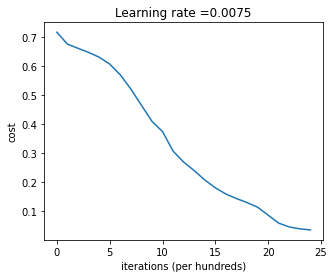

In [151]:
parameters,mypredL = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [152]:
predictions_train = predict(train_x,train_y,parameters,"L")
print ("Accuracy:",predictions_train)

Accuracy: 0.9952153110047847


In [153]:
predictions_test = predict(test_x, test_y, parameters,"L")
print ("Accuracy:",predictions_test)

Accuracy: 0.78


cat(closer to 1)/noncat(closer to 0): [[0.406822]]


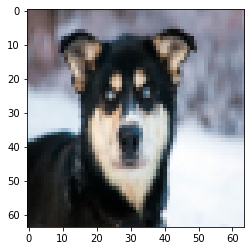

In [154]:
#from skimage.transform import resize
#my_image = resize(image, output_shape=(64, 64)).reshape((1, 64 * 64 * 3)).T
my_image = "test9-cat.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
image = np.array(plt.imread(fname))
plt.imshow(image)
num_px = np.array(image).shape[0]
image = image.reshape(1,image.shape[0]*image.shape[1]*image.shape[2]).T
image = image/255.
w="L"
if (w=="L"):
        z4=L_model_forward(image,parameters)[0]
if (w=="2"):
        z4= linear_activation_forward(image,parameters["W1"],parameters["b1"],"relu")[0]
        z4= linear_activation_forward(z4,parameters["W2"],parameters["b2"],"sigmoid")[0]
#z4=z4>0.5
print("cat(closer to 1)/noncat(closer to 0):",z4)